# Markov Chain Monte Carlo workshop

# Exercise 1: fitting an absorption line in a stellar spectrum with MCMC

We downloaded the spectrum of an O/B transition star from the *SDSS Spectral Cross-correlation Templates*:

http://www.sdss2.org/dr3/algorithms/spectemplates/index.html.

The following cells import the necessary packages and plot the data.

<IPython.core.display.Javascript object>


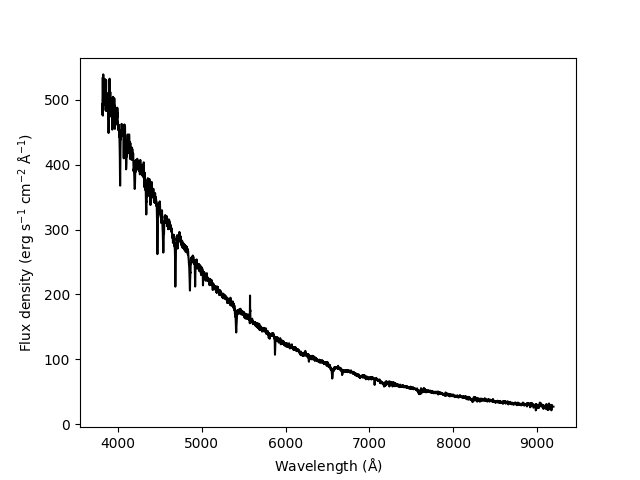

In [1]:
%matplotlib notebook

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy.stats as st
import emcee
import corner

# load the data
PATH = "data/spDR2-001.fit"
hdulist = fits.open(PATH)
data = hdulist[0].data
spectrum_flux = data[0]

# get the x-axis values
coeff0 = 3.5815             # logarithm of wavelength (in angstrom)
coeff1 = 0.0001             # log(A/pix)
wavelengths = 10.0 ** (coeff0 + coeff1 * np.arange(len(spectrum_flux)))

plt.figure()
plt.plot(wavelengths, spectrum_flux, "k-")
plt.xlabel("Wavelength ($\mathrm{\AA}$)")
plt.ylabel("Flux density ($\mathrm{erg\ s^{-1}\ cm^{-2}\ \AA^{-1}}$)")
plt.show()

## Cutting a window around the He I absorption line

We zoom in a region around the wavelength of an absorption line corresponding to He I.

*Use the `draw_model_parameters` to toggle on/off the model parameter visual aids...*

<IPython.core.display.Javascript object>


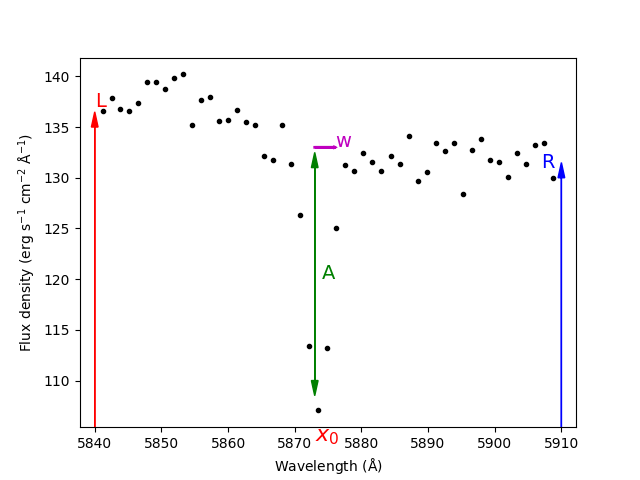

In [2]:
# cut the window of interest...
He_min = 5840
He_max = 5910
window = (wavelengths > He_min) & (wavelengths < He_max)
x = wavelengths[window]
y = spectrum_flux[window]

# ...and plot it along with hints on the parameters
draw_model_parameters = True
plt.figure()
plt.plot(x, y, "k.")
if draw_model_parameters:
    x1, x2, y1, y2 = plt.axis()
    plt.arrow(5840, y1, 0, 135 - y1, color="r", head_width=1.0)
    plt.arrow(5910, y1, 0, 130 - y1, color="b", head_width=1.0)
    plt.arrow(5873, 110, 0, 131 - 110, color="g", head_width=1.0)
    plt.arrow(5873, 131, 0, 110 - 131, color="g", head_width=1.0)
    plt.arrow(5873, 133, 3, 0, color="m", linewidth=2)
    plt.text(5840, 137, "L", color="r", fontsize=14)
    plt.text(5907, 131, "R", color="b", fontsize=14)
    plt.text(5874, 120, "A", color="g", fontsize=14)
    plt.text(5876, 133, "w", color="m", fontsize=14)
    plt.text(5873, 104, "$x_0$", color="r", fontsize=16)
plt.xlabel("Wavelength ($\mathrm{\AA}$)")
plt.ylabel("Flux density ($\mathrm{erg\ s^{-1}\ cm^{-2}\ \AA^{-1}}$)")
plt.show()

##### Model for the underlying shape

$$\huge y_m(x) = \underbrace{a + b x}_\textrm{continuum} + A
  \underbrace {e^{-\frac{\left(x - x_0\right)^2}{2 w^2}}}_\textrm{absorption}$$

where the slope is computed from $L$ and $R$ and the $x$-axis positions they refer to: the minimum and maximum of $x_i$ respectively:

$$ \large b = \frac{R - L}{\max\left\{x_i\right\} - \min\left\{x_i\right\}}$$

Similarly, the intercept is given by:

$$ \large a = L - b \min\left\{x_i\right\} $$

##### Model for the observational data $(x_i, y_i)$

$$ \large y_i \sim \mathcal{N}\left(y_m(x_j), \sigma\right)$$

denoting that the data are normally distributed around the model with an **unknown** standard deviation $\sigma$.

## Part A: set the prior, likelihood and posterior functions

In [3]:
# set the names of the parameters (useful for reporting stuff...)
param_names = ["L", "R", "A", "x0", "w"]

xmin, xmax = min(x), max(x)    # used to convert L and R values to intercept and slope

# set minimum and maximum bounds for the parameters
min_L, max_L = 125.0, 145.0
min_R, max_R = 125.0, 145.0
min_A, max_A = -50.0, -10.0
min_x0, max_x0 = 5860, 5890
min_w, max_w = 0.5, 10.0

def model(theta, x):
    L, R, A, x0, w = theta
    b = (R - L) / (xmax - xmin)
    a = L - b * xmin
    return a + b * x + A * np.exp(-(x - x0) ** 2.0 / (2.0 * w ** 2.0))    # Gaussian
    #return a + b * x + A * 1.0 / (1.0 + ((x - x0) / w) ** 2.0)            # Lorentzian

def log_prior(theta):
    L, R, A, x0, w = theta
    if min_L < L < max_L and min_R < R < max_R and min_A < A < max_A and min_x0 < x0 < max_x0 and min_w < w < max_w:
        return 0.0
    return -np.inf
    
def log_likelihood(theta, x, y):
    return -np.sum((y - model(theta, x)) ** 2.0)

def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)

## Part B: set the MCMC

Feel free to change the number of walkers and steps if you see poor convergence in the following parts of the exercise.

In [4]:
n_walkers = 200
n_dim = 5
n_steps = 500

# random initial positions for walkers
L_initial = np.random.uniform(min_L, max_L, size=n_walkers)
R_initial = np.random.uniform(min_R, max_R, size=n_walkers)
A_initial = np.random.uniform(min_A, max_A, size=n_walkers)
x0_initial = np.random.uniform(min_x0, max_x0, size=n_walkers)
w_initial = np.random.uniform(min_w, max_w, size=n_walkers)

# code them in a matrix
p_initial = np.array([L_initial, R_initial, A_initial, x0_initial, w_initial]).T

## Part C: run the MCMC

In [5]:
sampler = emcee.EnsembleSampler(nwalkers=n_walkers, dim=n_dim, lnpostfn=log_posterior, args=(x, y))
result = sampler.run_mcmc(p_initial, N=n_steps)

## Pard D: looking at the chains

<IPython.core.display.Javascript object>


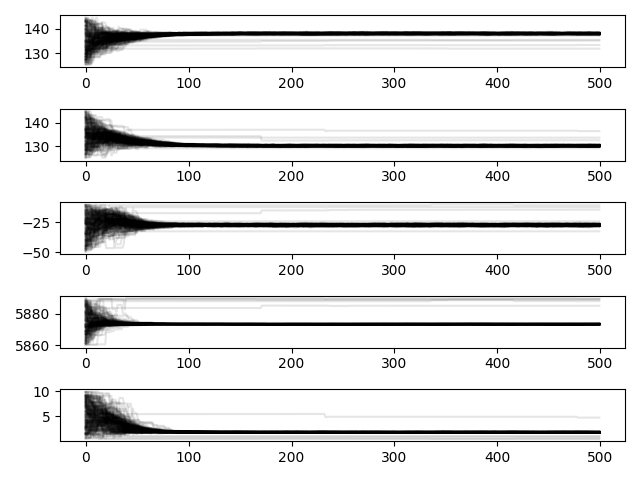

In [6]:
plt.figure()
# for each parameter...
for i in range(n_dim):
    param_name = param_names[i]
    plt.subplot(n_dim, 1, i + 1)
    # ...plot all chains
    for j in range(n_walkers):
        chain = sampler.chain[j, :, i]
        plt.plot(chain, "k-", alpha=0.1)
plt.tight_layout()
plt.show()

## Part E: burn in phase and corner plot

Select the number of steps of the burn in phse.

If the corner plot is too *noisy* use the `percentage_to_plot` to tell `corner` to avoid outliers. $1.0$ means it plots everything while $0.95$ means it will throw away $2.5\%$ of the lowest and higher values.

<IPython.core.display.Javascript object>


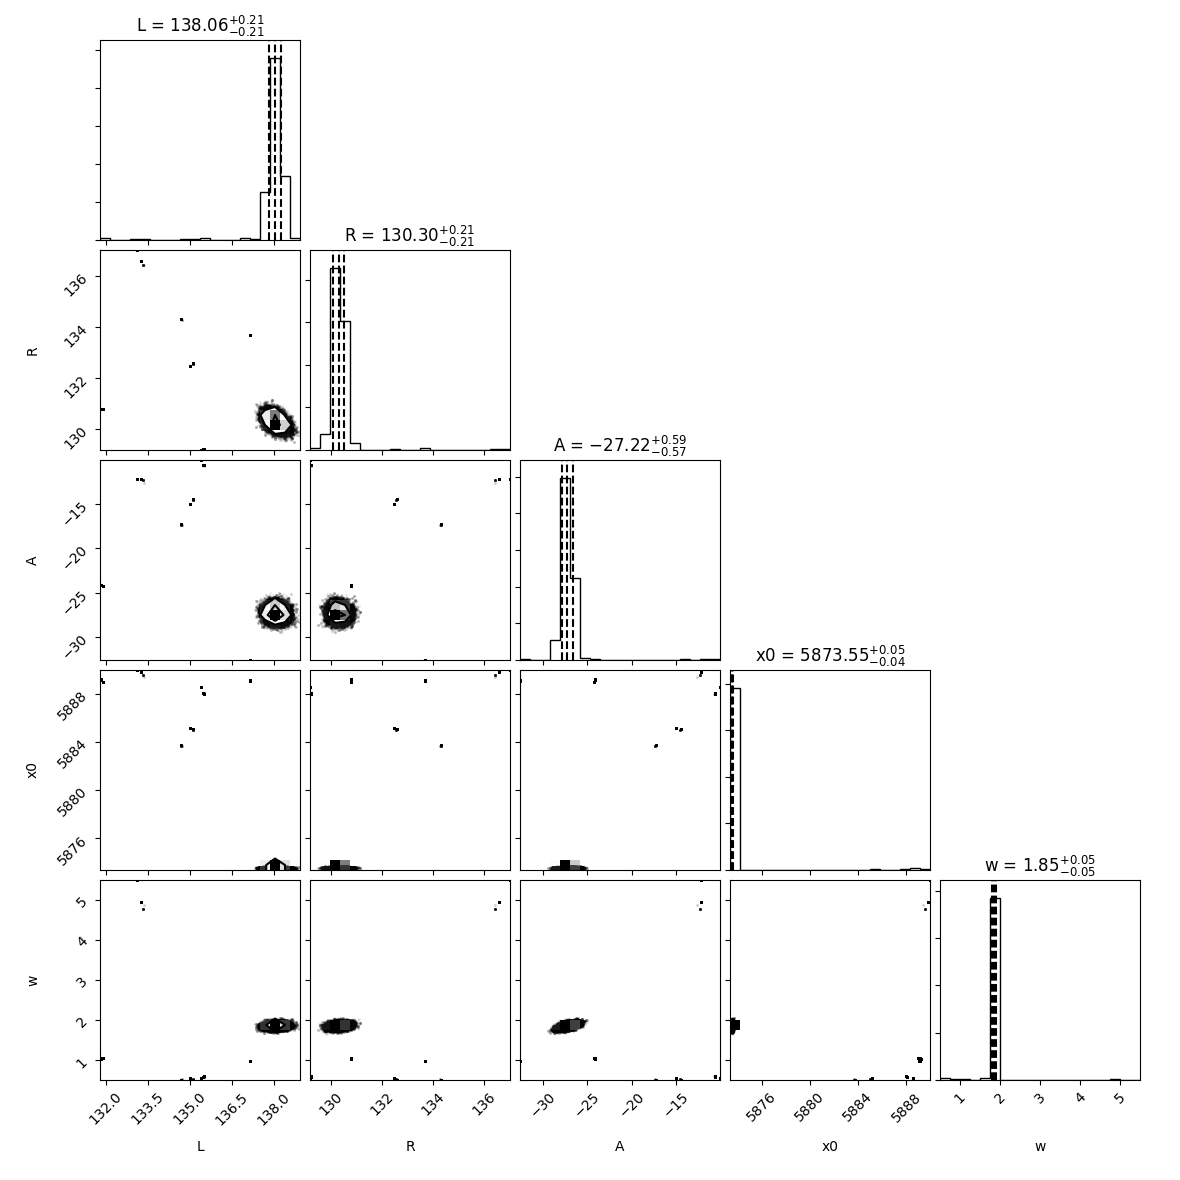

In [7]:
n_burnin = 100

percentage_to_plot = 1.0

converged_chain = sampler.chain[:, n_burnin:, :]
flat_converged_chain = converged_chain.reshape(converged_chain.shape[0] * converged_chain.shape[1], -1)

fig = corner.corner(flat_converged_chain,
                    quantiles=[0.16, 0.5, 0.84], 
                    labels=param_names, 
                    show_titles=True,
                    range=[percentage_to_plot] * n_dim)

#fig.set_size_inches((10, 8))

## Part F: Best fit value of the parameters

Use the distribution of the parameters to estimate the *best fit values*. What is your statistic of choice?

In [8]:
optimal_parameters = []

for dim in range(n_dim):
    converged_values = sampler.chain[:, n_burnin:, dim].flatten()
    optimal_value = np.median(converged_values)
    print("{} = {:.6g}".format(param_names[dim], optimal_value))
    optimal_parameters.append(np.median(converged_values))

L = 138.063
R = 130.3
A = -27.218
x0 = 5873.55
w = 1.85419


## Part G: use the best fit values to plot the fitted model along with the data

<IPython.core.display.Javascript object>


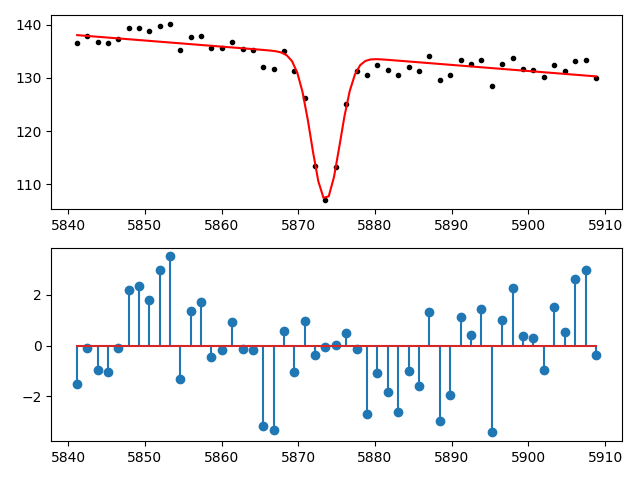

In [9]:
plt.figure()

# plot the data and the fit
plt.subplot(211)
plt.plot(x, y, "k.")
x_model = np.linspace(xmin, xmax, 100)
y_model = model(optimal_parameters, x_model)
plt.plot(x_model, y_model, "r-")

# plot the residuals
plt.subplot(212)
residuals = y - model(optimal_parameters, x)
plt.stem(x, residuals, use_line_collection=True)
plt.tight_layout()
plt.show()

## Question 1

What is the statistic we should use for the best fit parameter value? The mean value, the median, the mode?

## Question 2

Is the contiuum modelled good enough with a line?

## Part F

The SDSS site reports that the redshift of this star is $z = -0.0003$. Can you confirm this?

* the rest frame wavelength of the He I line is $5875.624\ \rm \mathring A$.
* the redshift is computed using the formula:

$$ 1 + z = \frac{\lambda_{\rm obs}}{\lambda_{\rm rest}} $$

In [10]:
He_obs = optimal_parameters[3]
He_true = 5875.624

z = He_obs / He_true - 1
print("Redshift: {:.3g}".format(z))

Redshift: -0.000353


## Question 3

The estimate of the redshift from the He line is not very good. Can you think of way to use the whole spectrum?

# Exercise 2: using a Lorentzian profile

Use the Lorentizan function to model the shape of the absorption line. Remember:

$$ \Large f(x) \propto \frac{1}{1 + \left(\frac{x - x_0}{\gamma}\right)^2} $$

Do the results change significantly?

# Exercise 3: *strict* priors...

The ranges you selected for the parameters might be narrow or wide. 

For example, really narrow is to allow `x0` vary only around the absorption line.

On the other hand, really wide is to use the minimum and maximum $x$-axis values.

Try to change the parameter ranges and observe:

* Does the MCMC converge?

* Are there any other solutions that we miss by using strict priors?

* Are there parameters that *need more guidance* than others?

Report your findings!

# Extra credit exercise: fit another absorption/emission feature!

Use the original data to find another absorption (or even emission) line feature. Then select a window around it. Can you fit it by following all the steps of the 1st exercise? What is the redshift?

# Final remarks

* Should the number of walkers depend on the number of dimensions?

* In the next days we will also see how fitting a spectrum can be performed by Machine Learning Regression methods.